# Legal Pickup and Dropoff in OpenAI Gym Taxi-v3

This notebook demonstrates how to use the OpenAI Gymnasium Taxi-v3 environment with human rendering. It shows how to programmatically perform a legal passenger pickup and dropoff without incurring any penalties.

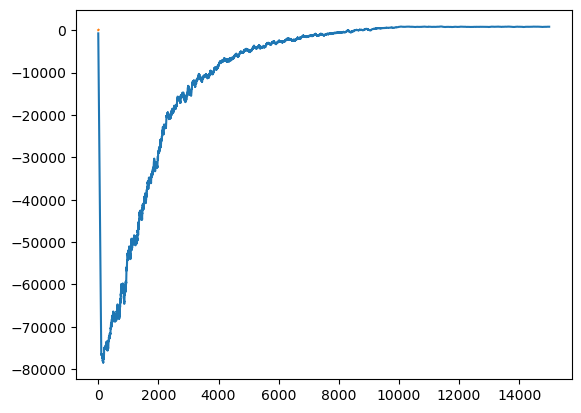

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def run(episodes, is_training=True, render=False):

    env = gym.make('Taxi-v3', render_mode='human' if render else None)

    if(is_training):
        q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 500 x 6 array
    else:
        f = open('taxi.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.9 # alpha or learning rate
    discount_factor_g = 0.9 # gamma or discount rate. Near 0: more weight/reward placed on immediate state. Near 1: more on future state.
    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 0.0001        # epsilon decay rate. 1/0.0001 = 10,000
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        rewards = 0
        while(not terminated and not truncated):
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
            else:
                action = np.argmax(q[state,:])

            new_state,reward,terminated,truncated,_ = env.step(action)

            rewards += reward

            if is_training:
                q[state,action] = q[state,action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state,:]) - q[state,action]
                )

            state = new_state

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if(epsilon==0):
            learning_rate_a = 0.0001


        rewards_per_episode[i] = rewards

    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)
    plt.savefig('taxi.png')

    if is_training:
        f = open("taxi.pkl","wb")
        pickle.dump(q, f)
        f.close()

if __name__ == '__main__':
    run(15000)

    run(10, is_training=False, render=True)
